4.1 Klasifikavimo Šablono Sudarymas
1. Pasirinkti duomenų aibę, kurioje yra dvi klasės.
2. Suformuoti dvi duomenų aibes:
    - Originalus požymių rinkinys.
    - Požymių rinkinys, naudojant dimensijos mažinimo algoritmą.
3. Pateikti klasių aprašomąsias statistikas (pvz., vidurkis, mediana, standartinis nuokrypis).
4. Padalinti duomenų aibę į mokymo ir validavimo aibes santykiu 80% ir 20%.
5. 50% CHECK PASIEMIAU KNN, TU IMK KITA Pasirinkti klasifikatorių (KNN, Naive Bayes, sprendimų medis, atsitiktinis miškas).
6. Apmokyti klasifikatorių ir atlikti klasifikaciją.
7. Aprašyti pasirinkto klasifikatoriaus veikimo principus.
8. Apskaičiuoti sumaišymo matricą (confusion matrix).
9. Apskaičiuoti accuracy, precision, recall ir F1-matą.
10. DOC WORK Paaiškinti, kuo šie matai skiriasi tarpusavyje.
11. 50% DONE Išnagrinėti, kaip keičiasi klasifikavimo rezultatai keičiant klasifikatoriaus parametrus.
12. Pateikti palyginimo rezultatus lentelėje.
13. Nustatyti optimalius klasifikatoriaus parametrus.
14. Vizualizuoti klasifikavimo rezultatus grafiškai.
15. Išnagrinėti taškus, kur klasifikatorius dažniausiai klydo, ir aprašyti jų savybes.

1. Įvertinti klasifikavimo kokybės rezultatus, naudojant šias strategijas:
    - Išlaikymo (holdout validation).
    - Kryžminio validavimo (k-fold cross-validation).
2. Palyginti klasifikavimo rezultatus, taikant skirtingas validavimo strategijas.
3. Vizualizuoti ROC kreives.
4. Apskaičiuoti AUC matą.
5. Palyginti skirtingų klasifikatorių accuracy, precision, recall ir F1-mato reikšmes.
6. Pateikti palyginimo rezultatus lentelėje.
7. Pateikti apibendrintas išvadas, remiantis rezultatais.

In [1]:
# importing libraries

# libraries for file manipulation
import pandas as pd
import numpy as np

# libraries for easier visualisation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# libraries for dimensionality reduction
import scipy.stats as stats
from sklearn import manifold
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, label_binarize

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import gaussian_kde

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, make_scorer

#from sklearn import metrics
from matplotlib import cm
# setting options
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)


In [3]:
# importing dataset
df_orig = pd.read_csv("D:\Documents\Studijos\ML\star_classification.csv", delimiter=',')

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\edvar\AppData\Local\Temp\ipykernel_12524\2958153930.py:2: SyntaxWarning: invalid escape sequence '\D'
  df_orig = pd.read_csv("D:\Documents\Studijos\ML\star_classification.csv", delimiter=',')


## Preparing data

In [4]:
df_orig.drop(columns=['obj_ID', 'alpha', 'delta', 'spec_obj_ID', 'rerun_ID', 'MJD'], inplace=True)

# panaikinti ekstremalių atsiskyrėlių vieną eilutę, kurioje reikšmės yra -9999
df_orig = df_orig[(df_orig[['u', 'g', 'r', 'i', 'z']] != -9999).all(axis=1)]

# encoding labels
df_orig.replace(['GALAXY', 'QSO', 'STAR'], [0, 1, 2], inplace=True)

C:\Users\edvar\AppData\Local\Temp\ipykernel_12524\3828237075.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_orig.replace(['GALAXY', 'QSO', 'STAR'], [0, 1, 2], inplace=True)


In [5]:
# Set a random seed for reproducibility
random_seed = 2

# 1875 objects per class, 3 classes, so training set would have total of 3000 objects
df = df_orig.groupby('class', group_keys=False).apply(
    lambda x: x.sample(n=1875, random_state=random_seed)
).reset_index(drop=True)

# only 0 ir 2 klases
df = df[df['class'] != 2].reset_index(drop=True)

# kiti masyvai nebuvo normalizuot, nes jie buvo pavadinimai, kampo laipsniai, kategorijos ar ID
normalization_cols = ['redshift', 'u', 'g', 'r', 'i', 'z']
# normalization

dfminmax = df.copy()
for col in normalization_cols:

    #min-max normalization
    dfminmax[col] = (dfminmax[col] - dfminmax[col].min()) / (dfminmax[col].max() - dfminmax[col].min())

C:\Users\edvar\AppData\Local\Temp\ipykernel_12524\1388758724.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_orig.groupby('class', group_keys=False).apply(


In [6]:
dfminmax.head()

,u,g,r,i,z,run_ID,cam_col,field_ID,class,redshift,plate,fiber_ID
0,0.262928,0.269962,0.305953,0.303675,0.334140,3919,5,32,0,0.009024,1377,420
1,0.370197,0.403489,0.435608,0.416880,0.461959,3840,2,241,0,0.026067,1460,191
2,0.630132,0.714054,0.661926,0.584229,0.614032,6366,1,131,0,0.085069,6129,150
3,0.571142,0.568189,0.557295,0.527849,0.573811,3919,3,47,0,0.031145,8847,32
4,0.398920,0.369402,0.372596,0.352503,0.374306,5935,3,142,0,0.014186,2436,194


In [7]:
dfminmax.describe()

,u,g,r,i,z,run_ID,cam_col,field_ID,class,redshift,plate,fiber_ID
count,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000
mean,0.553554,0.567326,0.600287,0.575135,0.626007,4538.986667,3.458667,187.930667,0.500000,0.150682,5991.353333,472.248533
std,0.153779,0.130514,0.137701,0.135934,0.154527,2006.732319,1.581020,145.382743,0.500067,0.130637,3036.527921,281.621754
min,0.000000,0.000000,0.000000,0.000000,0.000000,109.000000,1.000000,11.000000,0.000000,0.000000,274.000000,1.000000
25%,0.445102,0.499826,0.535350,0.508909,0.546452,3185.000000,2.000000,84.000000,0.000000,0.060935,4013.250000,234.000000
50%,0.545191,0.592381,0.630793,0.595148,0.644221,4187.000000,3.000000,148.000000,0.500000,0.104413,6263.000000,462.000000
75%,0.653307,0.651715,0.699891,0.675557,0.741953,5640.000000,5.000000,251.000000,1.000000,0.222368,8295.500000,710.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,8162.000000,6.000000,837.000000,1.000000,1.000000,12547.000000,1000.000000


In [8]:
feature_cols = ['redshift', 'u', 'g', 'r', 'i', 'z']
data_original = dfminmax[['redshift', 'u', 'g', 'r', 'i', 'z', 'class']].values

# PREP

### Training, testing data split

In [9]:
# Split each class into 80% for dfminmax
class_0 = dfminmax[dfminmax['class'] == 1]
class_2 = dfminmax[dfminmax['class'] == 0]

class_0_train, class_0_test = train_test_split(class_0, test_size=0.2, random_state=42)
class_2_train, class_2_test = train_test_split(class_2, test_size=0.2, random_state=42)


# Combine the two classes
dfminmax = pd.concat([class_0_train, class_2_train]).sample(frac=1, random_state=42).reset_index(drop=True)
dfminmax_test = pd.concat([class_0_test, class_2_test]).sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
# function to encapsulate and use same random_state for both classifications
def split_train_test(X, y, test_size=0.2, random_state=42, stratify=None):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify
    )
    return X_train, X_test, y_train, y_test


## PCA, LDA dimensionality reduction, class seperation %s

#### PCA, '1', '2' classes(ALL DATA, TRAINING AND TESTING) - there is no training and no testing ?

Explained variance ratio: [0.71711528 0.18800211]


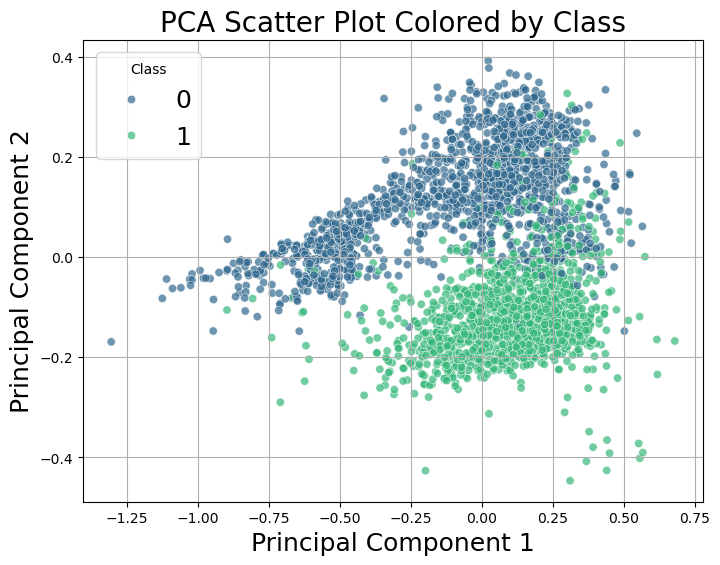

In [11]:
# Selecting the columns for PCA
data = dfminmax[['u', 'g', 'r', 'i', 'z', 'redshift']]

# Applying PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

# Adding PCA results to the DataFrame
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Adding the 'class' column to the PCA DataFrame for visualization
df_pca['class'] = dfminmax['class']

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance}")

# Plotting the PCA results colored by class
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_pca['PC1'],
    y=df_pca['PC2'],
    hue=df_pca['class'],
    palette='viridis',
    alpha=0.7
)
plt.title('PCA Scatter Plot Colored by Class', fontsize=20)
plt.xlabel('Principal Component 1', fontsize=18)
plt.ylabel('Principal Component 2', fontsize=18)
plt.legend(title='Class',fontsize=18)
plt.grid(True)
plt.show()

# Combine PCA results with original DataFrame
df_with_pca = pd.concat([dfminmax, df_pca[['PC1', 'PC2']]], axis=1)


In [12]:

X = df_pca[['PC1', 'PC2']].values  # PCA-transformed features
y = df_pca['class'].values         # Labels (class 1 and 2)

X_train, X_test, y_train, y_test = split_train_test(X, y, stratify=y)

# KNN

## KNN classifier for PCA

#### Testing 3 paramaters of KNN for PCA

Top 5 configurations based on F1-Score:
    n_neighbors   weights  p       f1
13           50   uniform  2 0.923320
8            10   uniform  1 0.923312
9            10   uniform  2 0.923303
5             5   uniform  2 0.919996
15           50  distance  2 0.919992

Most Optimal Configuration:
n_neighbors: 50, weights: uniform, p: 2, F1-Score: 0.92


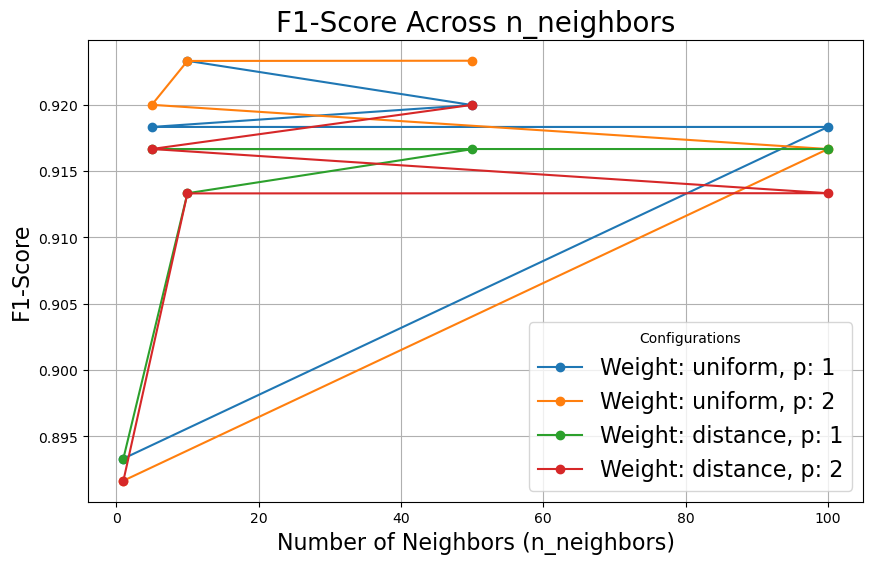

In [12]:
# Step 1: Define parameters to test
n_neighbors_values = [1, 5, 10, 50, 100]
weights_values = ['uniform', 'distance']
p_values = [1, 2]  # Manhattan (L1) and Euclidean (L2)

# Step 2: Store results
results = []

# Step 3: Test each combination
for n in n_neighbors_values:
    for weight in weights_values:
        for p in p_values:
            # Initialize and train KNN
            knn = KNeighborsClassifier(n_neighbors=n, weights=weight, p=p)
            knn.fit(X_train, y_train)
            
            # Predict
            y_pred = knn.predict(X_test)
            
            # Calculate F1-score
            f1 = f1_score(y_test, y_pred, average='weighted')
            
            # Store results
            results.append({
                'n_neighbors': n,
                'weights': weight,
                'p': p,
                'f1': f1
            })

# Step 4: Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results)

# Step 5: Display and sort results by F1-score
results_df = results_df.sort_values(by='f1', ascending=False)
print("Top 5 configurations based on F1-Score:")
print(results_df.head())

# Step 6: Display the most optimal configuration
best_config = results_df.iloc[0]
print("\nMost Optimal Configuration:")
print(f"n_neighbors: {best_config['n_neighbors']}, weights: {best_config['weights']}, p: {best_config['p']}, F1-Score: {best_config['f1']:.2f}")

# Step 7: Visualize F1-score across n_neighbors
plt.figure(figsize=(10, 6))
for weight in weights_values:
    for p in p_values:
        subset = results_df[(results_df['weights'] == weight) & (results_df['p'] == p)]
        plt.plot(subset['n_neighbors'], subset['f1'], marker='o', label=f"Weight: {weight}, p: {p}")

plt.title('F1-Score Across n_neighbors', fontsize=20)
plt.xlabel('Number of Neighbors (n_neighbors)', fontsize=16)
plt.ylabel('F1-Score', fontsize=16)
plt.legend(title="Configurations", loc='lower right', fontsize=16)
plt.grid(True)
plt.show()


#### Optimal KNN paramaters for PCA: n_neighbors=50, weights='distance', p=1


Confusion Matrix:
[[279  21]
 [ 29 271]]


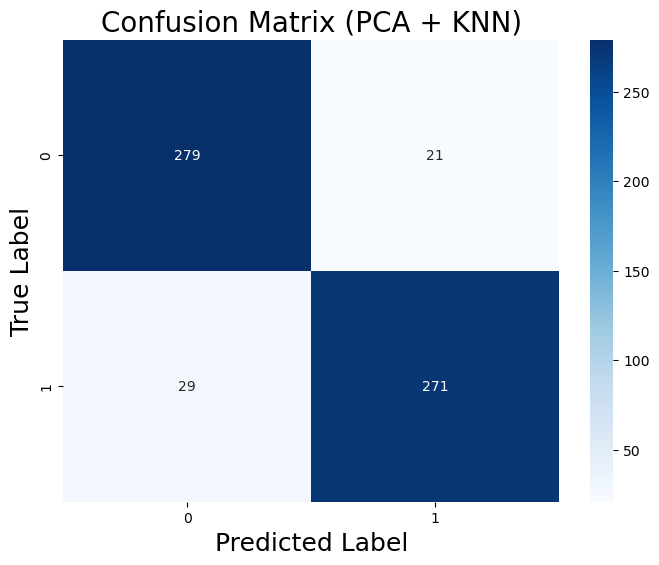

Overall Accuracy (PCA + KNN): 0.92
Precision (Weighted): 0.92
Recall (Weighted): 0.92
F1-Score (Weighted): 0.92

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       300
           1       0.93      0.90      0.92       300

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



In [13]:

# Step 3: Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=1)  # k=1, distance-weighted
knn.fit(X_train, y_train)

# Step 4: Predict on the test set
y_pred = knn.predict(X_test)

# Step 5: Evaluate the model
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(y)), yticklabels=sorted(set(y)))
plt.title("Confusion Matrix (PCA + KNN)", fontsize=20)
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
plt.show()

# Step 6: Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Weighted average for multiclass
recall = recall_score(y_test, y_pred, average='weighted')        # Weighted average for multiclass
f1 = f1_score(y_test, y_pred, average='weighted')                # Weighted average for multiclass

# Step 7: Display metrics
print(f"Overall Accuracy (PCA + KNN): {accuracy:.2f}")
print(f"Precision (Weighted): {precision:.2f}")
print(f"Recall (Weighted): {recall:.2f}")
print(f"F1-Score (Weighted): {f1:.2f}")

# Step 8: Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


#### KNN results for PCA - correct vs misclassified

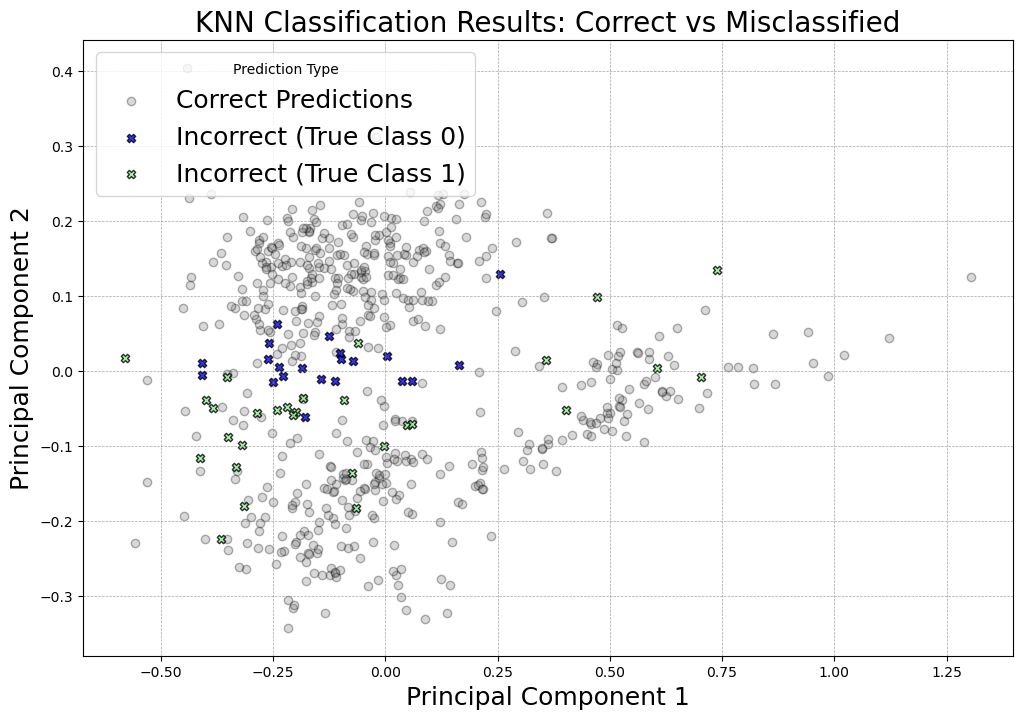

In [14]:
from sklearn.decomposition import PCA

# Step 1: Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Step 2: Create a DataFrame for the test results
test_results = pd.DataFrame(X_test_pca, columns=['PC1', 'PC2'])
test_results['true_label'] = y_test
test_results['predicted_label'] = y_pred
test_results['is_correct'] = test_results['true_label'] == test_results['predicted_label']

# Step 3: Separate correct and incorrect classifications
correct_points = test_results[test_results['is_correct']]
incorrect_points = test_results[~test_results['is_correct']]

# Step 4: Visualize the classifications
plt.figure(figsize=(12, 8))

# Plot Correct Predictions (grey color with low opacity)
plt.scatter(
    correct_points['PC1'],
    correct_points['PC2'],
    c='grey',
    marker='o',
    alpha=0.3,  # Low opacity for correct points
    edgecolor='k',
    label='Correct Predictions'
)

# Plot Incorrect Predictions (different colors for each misclassified class)
for class_label, color in zip(sorted(set(y_test)), ['blue', 'lightgreen', 'red']):
    class_incorrect = incorrect_points[incorrect_points['true_label'] == class_label]
    plt.scatter(
        class_incorrect['PC1'],
        class_incorrect['PC2'],
        c=color,
        marker='X',
        alpha=0.8,  # Higher opacity for incorrect points
        edgecolor='k',
        label=f'Incorrect (True Class {class_label})'
    )

# Step 5: Add plot details
plt.title("KNN Classification Results: Correct vs Misclassified", fontsize=20)
plt.xlabel("Principal Component 1", fontsize=18)
plt.ylabel("Principal Component 2", fontsize=18)

# Add legend
plt.legend(title="Prediction Type", loc='upper left', fontsize=18)

# Add grid
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()


#### Decision boundaries grid(NEZINAU AR REIKIA?)

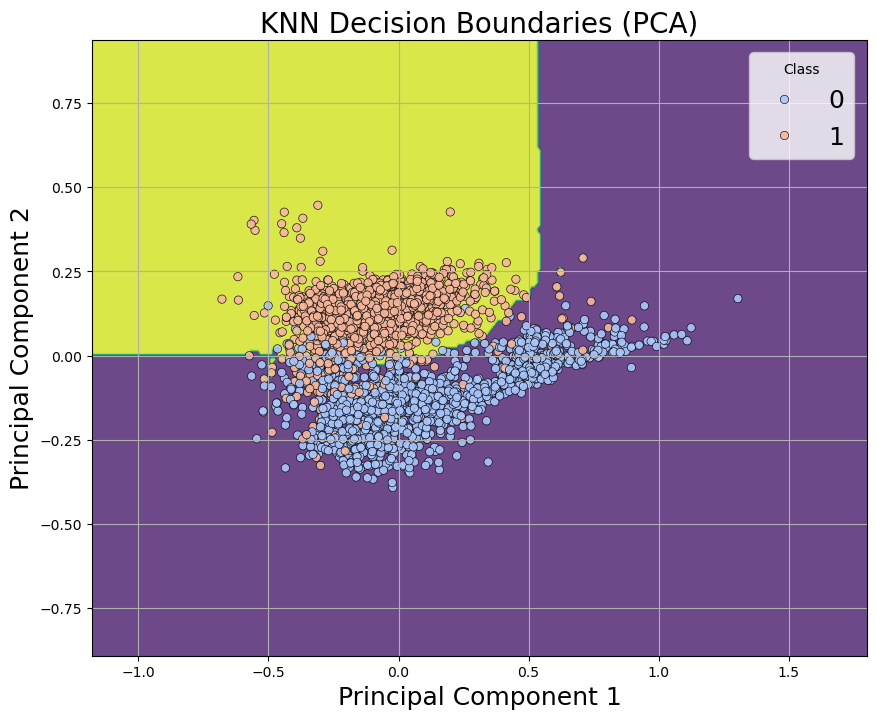

In [15]:
# Ensure X_test, y_test, and the trained knn model exist from PCA workflow
X = df_pca[['PC1', 'PC2']].values
y = df_pca['class'].values

# Create a mesh grid over the PCA feature space
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict on the grid
grid = np.c_[xx.ravel(), yy.ravel()]
Z = knn.predict(grid)
Z = Z.reshape(xx.shape)

# Plot decision boundaries
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')  # Decision regions

# Plot data points
sns.scatterplot(
    x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', edgecolor='k', alpha=0.9
)

# Add titles and labels
plt.title("KNN Decision Boundaries (PCA)", fontsize=20)
plt.xlabel("Principal Component 1", fontsize=18)
plt.ylabel("Principal Component 2", fontsize=18)
plt.legend(title="Class", fontsize=18)
plt.grid(True)
plt.show()


## KNN for original data(6 features, not dimensionality reduced to 2 - more data, more precise)

#### Testing 3 paramaters of KNN for original 6 features

Top 5 configurations based on F1-Score:
    n_neighbors   weights  p       f1
4             5   uniform  1 0.946664
6             5  distance  1 0.946664
5             5   uniform  2 0.943328
7             5  distance  2 0.943328
11           10  distance  2 0.941663

Most Optimal Configuration:
n_neighbors: 5, weights: uniform, p: 1, F1-Score: 0.95


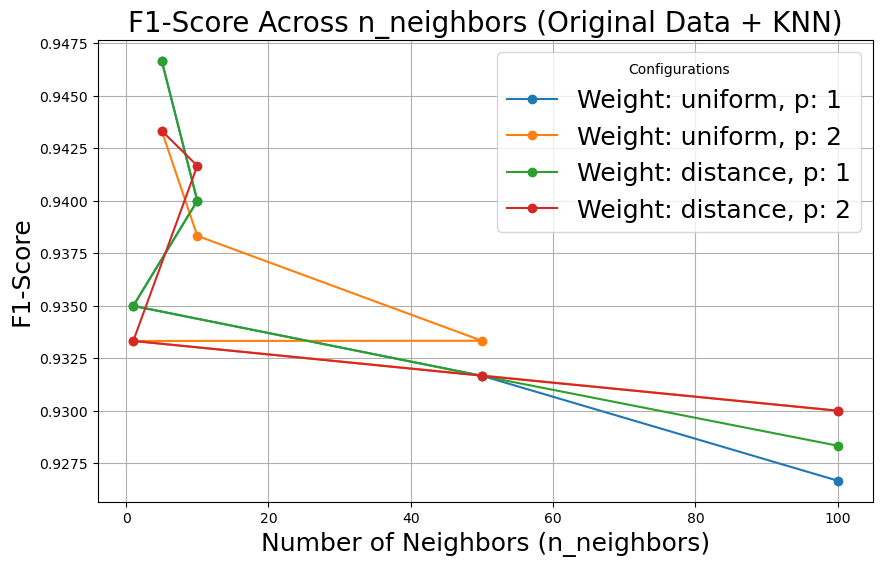

In [67]:
# Step 1: Extract original features and labels
X = dfminmax[['u', 'g', 'r', 'i', 'z', 'redshift']].values  # Original features
y = dfminmax['class'].values                               # Labels (class 1 and 2)

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = split_train_test(X, y, stratify=y)

# Step 4: Define parameters to test
n_neighbors_values = [1, 5, 10, 50, 100]
weights_values = ['uniform', 'distance']
p_values = [1, 2]  # Manhattan (L1) and Euclidean (L2)

# Step 5: Store results
results = []

# Step 6: Test each combination
for n in n_neighbors_values:
    for weight in weights_values:
        for p in p_values:
            # Initialize and train KNN
            knn = KNeighborsClassifier(n_neighbors=n, weights=weight, p=p)
            knn.fit(X_train, y_train)
            
            # Predict
            y_pred = knn.predict(X_test)
            
            # Calculate F1-score
            f1 = f1_score(y_test, y_pred, average='weighted')
            
            # Store results
            results.append({
                'n_neighbors': n,
                'weights': weight,
                'p': p,
                'f1': f1
            })

# Step 7: Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results)

# Step 8: Display and sort results by F1-score
results_df = results_df.sort_values(by='f1', ascending=False)
print("Top 5 configurations based on F1-Score:")
print(results_df.head())

# Step 9: Display the most optimal configuration
best_config = results_df.iloc[0]
print("\nMost Optimal Configuration:")
print(f"n_neighbors: {best_config['n_neighbors']}, weights: {best_config['weights']}, p: {best_config['p']}, F1-Score: {best_config['f1']:.2f}")

# Step 10: Visualize F1-score across n_neighbors
plt.figure(figsize=(10, 6))
for weight in weights_values:
    for p in p_values:
        subset = results_df[(results_df['weights'] == weight) & (results_df['p'] == p)]
        plt.plot(subset['n_neighbors'], subset['f1'], marker='o', label=f"Weight: {weight}, p: {p}")

plt.title('F1-Score Across n_neighbors (Original Data + KNN)', fontsize=20)
plt.xlabel('Number of Neighbors (n_neighbors)', fontsize=18)
plt.ylabel('F1-Score', fontsize=18)
plt.legend(title="Configurations", loc='upper right', fontsize=18)
plt.grid(True)
plt.show()


#### Optimal KNN paramaters for PCA: n_neighbors=10, weights='uniform', p=1


Confusion Matrix:
[[285  15]
 [ 21 279]]


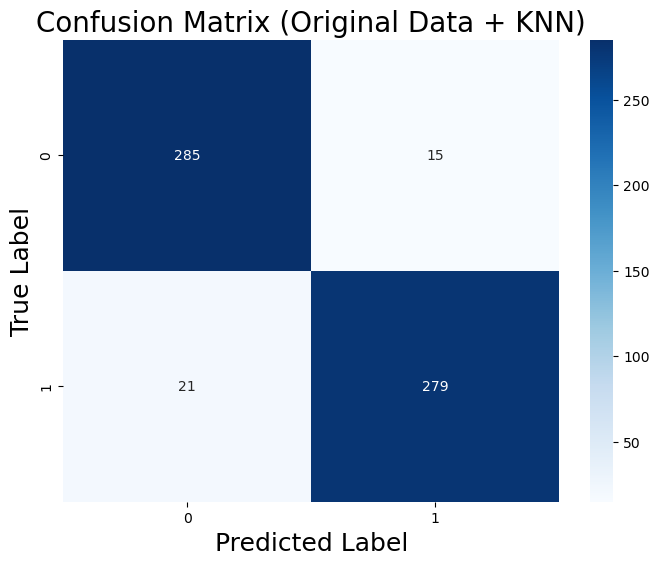

Overall Accuracy (Original Data + KNN): 0.94
Precision (Weighted): 0.94
Recall (Weighted): 0.94
F1-Score (Weighted): 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       300
           1       0.95      0.93      0.94       300

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



In [68]:
# Step 1: Extract original features and labels
X = dfminmax[['u', 'g', 'r', 'i', 'z', 'redshift']].values  # Original features
y = dfminmax['class'].values                               # Labels (class 1 and 2)


# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = split_train_test(X, y, stratify=y)

# Step 4: Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform', p=1)  # k=1, distance-weighted
knn.fit(X_train, y_train)

# Step 5: Predict on the test set
y_pred = knn.predict(X_test)

# Step 6: Evaluate the model
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(y)), yticklabels=sorted(set(y)))
plt.title("Confusion Matrix (Original Data + KNN)", fontsize=20)
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
plt.show()

# Step 7: Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Weighted average for multiclass
recall = recall_score(y_test, y_pred, average='weighted')        # Weighted average for multiclass
f1 = f1_score(y_test, y_pred, average='weighted')                # Weighted average for multiclass

# Step 8: Display metrics
print(f"Overall Accuracy (Original Data + KNN): {accuracy:.2f}")
print(f"Precision (Weighted): {precision:.2f}")
print(f"Recall (Weighted): {recall:.2f}")
print(f"F1-Score (Weighted): {f1:.2f}")

# Step 9: Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


### Correct vs missclassified

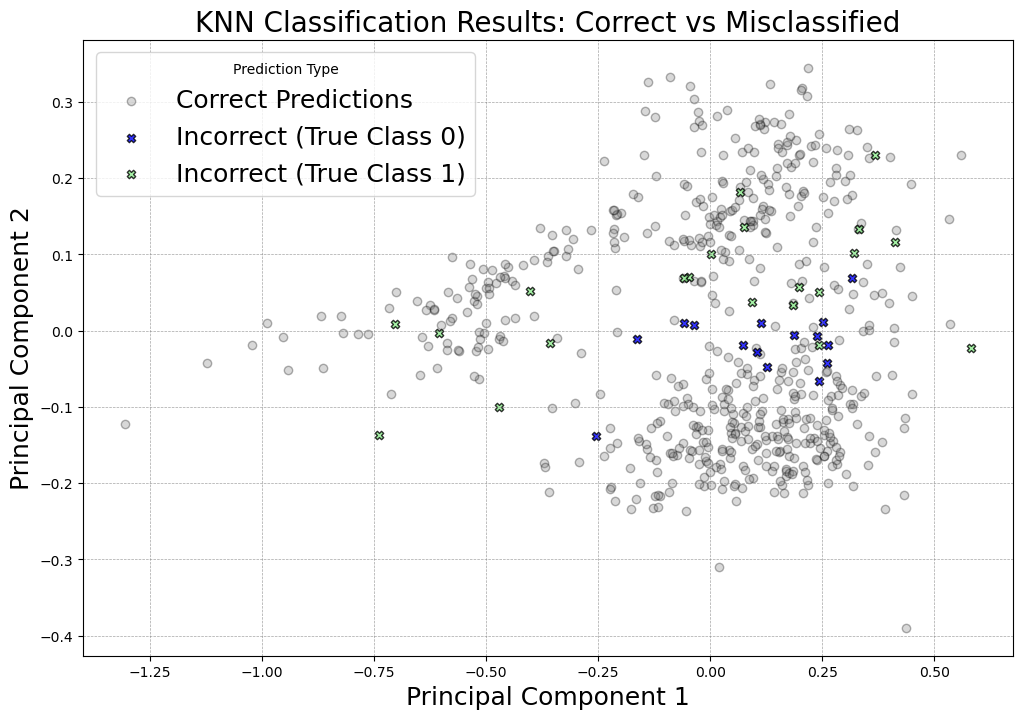

In [69]:
# Step 1: Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Step 2: Create a DataFrame for the test results
test_results = pd.DataFrame(X_test_pca, columns=['PC1', 'PC2'])
test_results['true_label'] = y_test
test_results['predicted_label'] = y_pred
test_results['is_correct'] = test_results['true_label'] == test_results['predicted_label']

# Step 3: Separate correct and incorrect classifications
correct_points = test_results[test_results['is_correct']]
incorrect_points = test_results[~test_results['is_correct']]

# Step 4: Visualize the classifications
plt.figure(figsize=(12, 8))

# Plot Correct Predictions (grey color with low opacity)
plt.scatter(
    correct_points['PC1'],
    correct_points['PC2'],
    c='grey',
    marker='o',
    alpha=0.3,  # Low opacity for correct points
    edgecolor='k',
    label='Correct Predictions'
)

# Plot Incorrect Predictions (different colors for each misclassified class)
for class_label, color in zip(sorted(set(y_test)), ['blue', 'lightgreen', 'red']):
    class_incorrect = incorrect_points[incorrect_points['true_label'] == class_label]
    plt.scatter(
        class_incorrect['PC1'],
        class_incorrect['PC2'],
        c=color,
        marker='X',
        alpha=0.8,  # Higher opacity for incorrect points
        edgecolor='k',
        label=f'Incorrect (True Class {class_label})'
    )

# Step 5: Add plot details
plt.title("KNN Classification Results: Correct vs Misclassified", fontsize=20)
plt.xlabel("Principal Component 1", fontsize=18)
plt.ylabel("Principal Component 2", fontsize=18)

# Add legend
plt.legend(title="Prediction Type", loc='upper left', fontsize=18)

# Add grid
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()


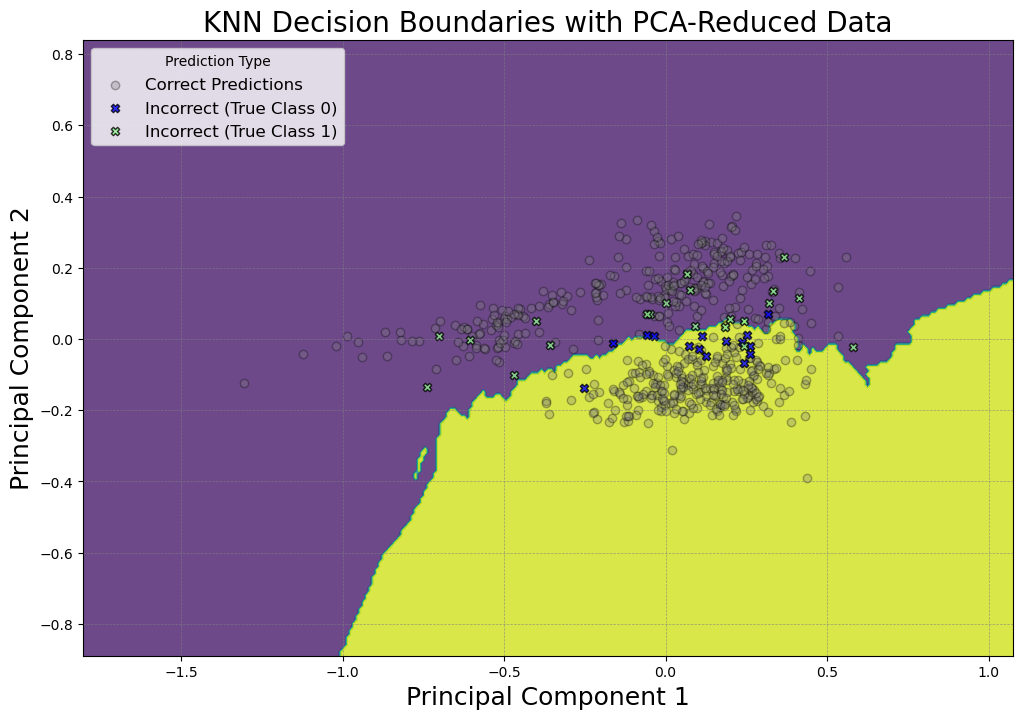

In [71]:
# Step 1: Create a mesh grid over the PCA-reduced space
x_min, x_max = X_test_pca[:, 0].min() - 0.5, X_test_pca[:, 0].max() + 0.5
y_min, y_max = X_test_pca[:, 1].min() - 0.5, X_test_pca[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Step 2: Predict on the mesh grid using the trained KNN model
grid = np.c_[xx.ravel(), yy.ravel()]
grid_original_space = pca.inverse_transform(grid)  # Map grid points back to the original space
Z = knn.predict(grid_original_space)  # Predict using the KNN model
Z = Z.reshape(xx.shape)

# Step 3: Visualize the decision boundaries
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')  # Decision regions

# Step 4: Overlay the classification points
# Correct Predictions (grey color with low opacity)
plt.scatter(
    correct_points['PC1'],
    correct_points['PC2'],
    c='grey',
    marker='o',
    alpha=0.3,
    edgecolor='k',
    label='Correct Predictions'
)

# Incorrect Predictions (different colors for each misclassified class)
for class_label, color in zip(sorted(set(y_test)), ['blue', 'lightgreen', 'red']):
    class_incorrect = incorrect_points[incorrect_points['true_label'] == class_label]
    plt.scatter(
        class_incorrect['PC1'],
        class_incorrect['PC2'],
        c=color,
        marker='X',
        alpha=0.8,
        edgecolor='k',
        label=f'Incorrect (True Class {class_label})'
    )

# Step 5: Add plot details
plt.title("KNN Decision Boundaries with PCA-Reduced Data", fontsize=20)
plt.xlabel("Principal Component 1", fontsize=18)
plt.ylabel("Principal Component 2", fontsize=18)

# Add legend and grid
plt.legend(title="Prediction Type", loc='upper left', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()


### K-fold cross-validation - original data with 6 features + KNN, PCA + KNN, LDA + KNN

             Dataset  Mean F1-Score  Std F1-Score
0  Original Features       0.950650      0.018673
1    PCA Transformed       0.934650      0.011475


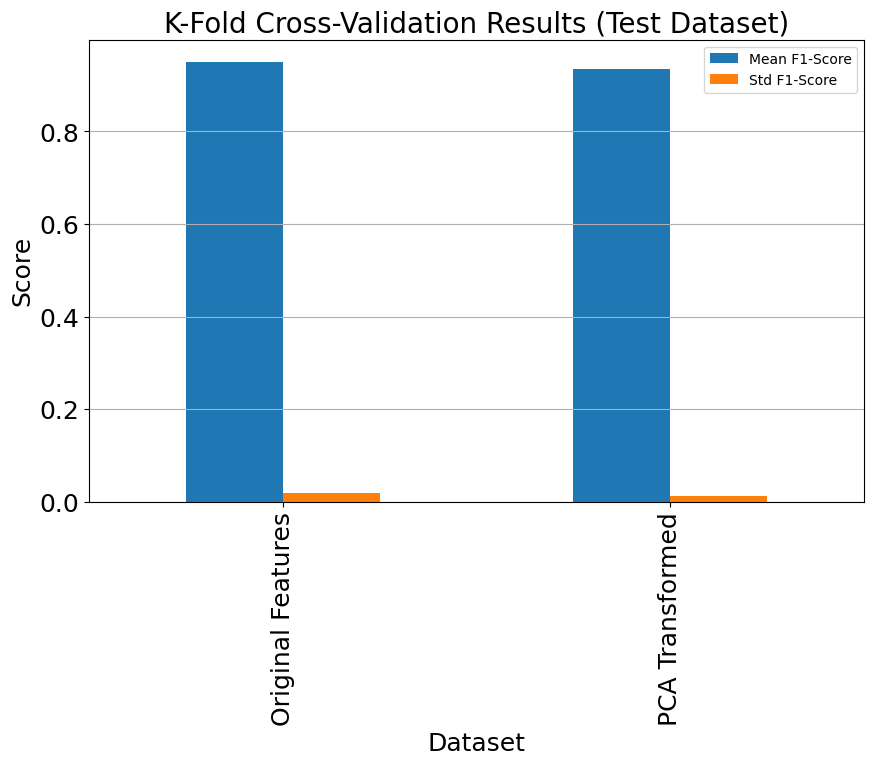

In [84]:


# Step 1: Prepare datasets
datasets = []

# Original 6 features
X_original = dfminmax_test[['u', 'g', 'r', 'i', 'z', 'redshift']].values
y_original = dfminmax_test['class'].values
datasets.append(("Original Features", X_original, y_original))

# Step 2: Apply PCA on dfminmax_test
pca = PCA(n_components=2)
X_pca_test = pca.fit_transform(X_original)  # Transform dfminmax_test features
df_pca_test = pd.DataFrame(X_pca_test, columns=['PC1', 'PC2'])
df_pca_test['class'] = y_original

# PCA-transformed features
X_pca = df_pca_test[['PC1', 'PC2']].values
y_pca = df_pca_test['class'].values
datasets.append(("PCA Transformed", X_pca, y_pca))

# Step 3: Perform k-fold cross-validation for each dataset
results = []
for name, X, y in datasets:
    result = evaluate_knn_with_kfold(X, y, name)
    results.append(result)

# Step 4: Display results
results_df = pd.DataFrame(results)
print(results_df)

# Step 5: Visualize results
results_df.plot(x="Dataset", y=["Mean F1-Score", "Std F1-Score"], kind="bar", figsize=(10, 6), legend=True, fontsize=18)
plt.title("K-Fold Cross-Validation Results (Test Dataset)", fontsize=20)
plt.xlabel("Dataset", fontsize=18)
plt.ylabel("Score", fontsize=18)
plt.grid(axis="y")
plt.show()


### ROC Curve(ROC is the graph, AUC is the value)

Computing ROC for Original Features...


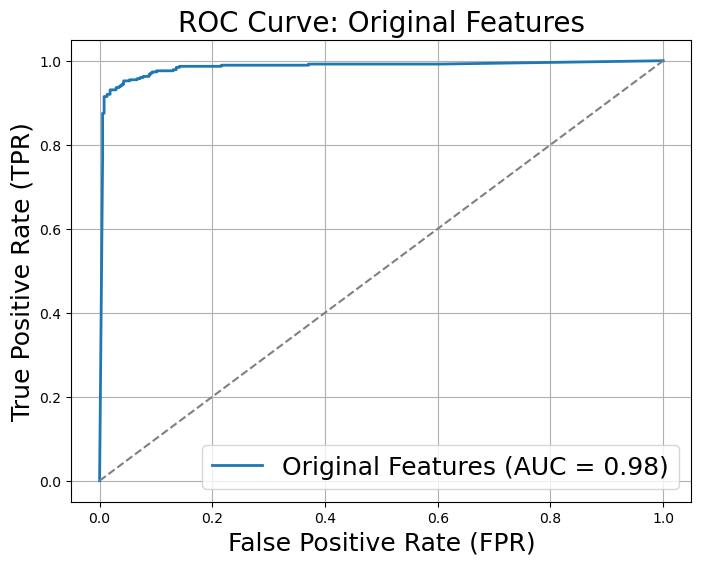

Computing ROC for PCA Transformed Features...


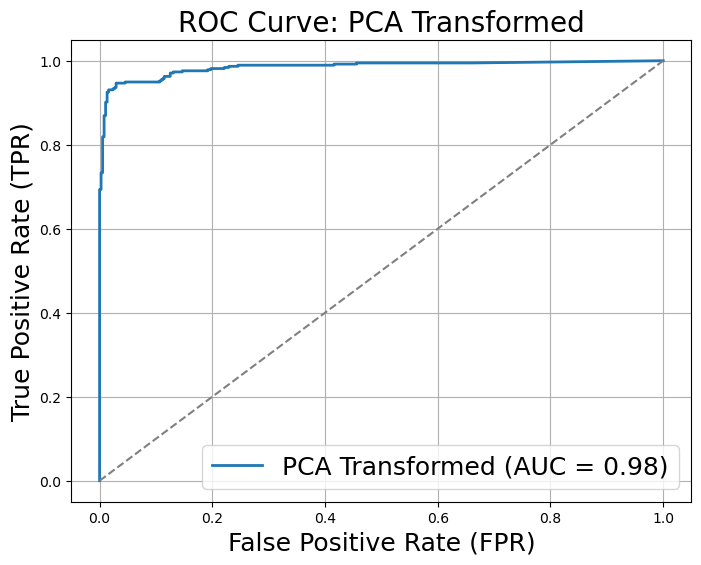

Original Features - AUC: 0.984608
PCA Transformed Features - AUC: 0.9848462222222223


In [87]:
# Define a function to compute and plot ROC for a dataset
def compute_and_plot_roc(X_train, X_test, y_train, y_test, name):
    # Step 1: Train the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2)
    knn.fit(X_train, y_train)
    
    # Step 2: Predict probabilities
    if len(np.unique(y_test)) == 2:  # Binary classification
        y_prob = knn.predict_proba(X_test)[:, 1]  # Probabilities for positive class
        fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)
        auc_score = roc_auc_score(y_test, y_prob)
    else:  # Multi-class classification (one-vs-all)
        y_binarized = label_binarize(y_test, classes=np.unique(y_test))
        y_prob = knn.predict_proba(X_test)
        fpr, tpr, auc_score = {}, {}, {}
        for i in range(y_binarized.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_prob[:, i])
            auc_score[i] = roc_auc_score(y_binarized[:, i], y_prob[:, i])
    
    # Step 3: Plot ROC curve
    plt.figure(figsize=(8, 6))
    if len(np.unique(y_test)) == 2:  # Binary
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})", linewidth=2)
    else:  # Multi-class
        for i in range(len(auc_score)):
            plt.plot(fpr[i], tpr[i], label=f"{name} - Class {i} (AUC = {auc_score[i]:.2f})", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random guessing line
    plt.title(f"ROC Curve: {name}", fontsize=20)
    plt.xlabel("False Positive Rate (FPR)", fontsize=18)
    plt.ylabel("True Positive Rate (TPR)", fontsize=18)
    plt.legend(loc="lower right", fontsize=18)
    plt.grid(True)
    plt.show()
    return auc_score

# Prepare original dataset
X_test_original = dfminmax_test[['u', 'g', 'r', 'i', 'z', 'redshift']].values
y_test_original = dfminmax_test['class'].values
scaler = StandardScaler()
X_test_original_scaled = scaler.fit_transform(X_test_original)

X_train_original = dfminmax[['u', 'g', 'r', 'i', 'z', 'redshift']].values
y_train_original = dfminmax['class'].values
X_train_original_scaled = scaler.fit_transform(X_train_original)

# PCA Transformation
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_original_scaled)
X_test_pca = pca.transform(X_test_original_scaled)

# Evaluate and plot ROC for each dataset
results = []

# Original Features
print("Computing ROC for Original Features...")
auc_original = compute_and_plot_roc(X_train_original_scaled, X_test_original_scaled, y_train_original, y_test_original, "Original Features")
results.append({"Dataset": "Original Features", "AUC": auc_original})

# PCA Transformed Features
print("Computing ROC for PCA Transformed Features...")
auc_pca = compute_and_plot_roc(X_train_pca, X_test_pca, y_train_original, y_test_original, "PCA Transformed")
results.append({"Dataset": "PCA Transformed Features", "AUC": auc_pca})

# Display results
for result in results:
    print(f"{result['Dataset']} - AUC: {result['AUC']}")


# RandomForest

## RandomForest classifier for PCA

#### Testing 3 parameters of RandomForest for PCA

Top 5 configurations based on F1-Score:
    n_estimators  max_depth max_features       f1
19           100          5         log2 0.928317
18           100          5         sqrt 0.928317
4             10         10         sqrt 0.925000
5             10         10         log2 0.925000
13            50         10         log2 0.924998

Most Optimal Configuration:
n_estimators: 100, max_depth: 5, max_features: log2, F1-Score: 0.93


<Figure size 1000x600 with 0 Axes>

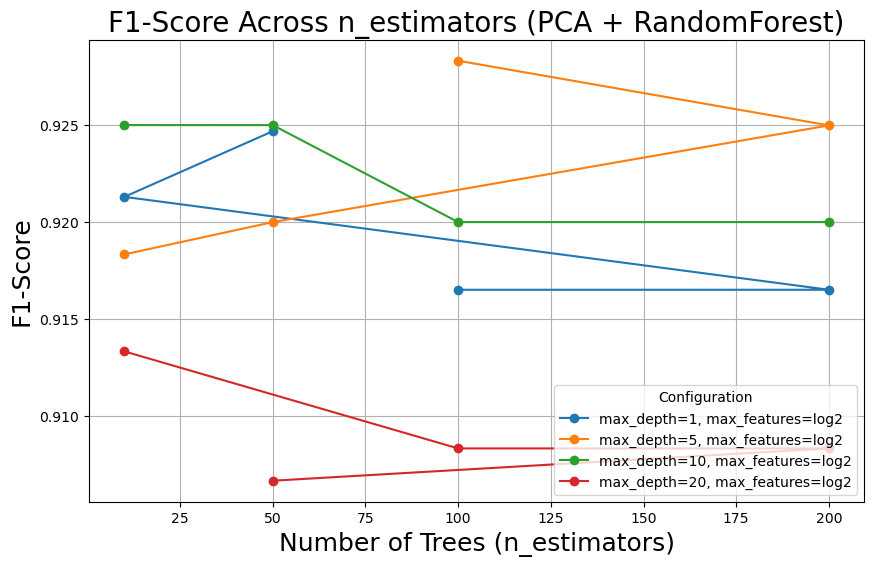

In [14]:
# Step 1: Define parameters to test
n_estimators_values = [10, 50, 100, 200]
max_depth_values = [1, 5, 10, 20]
max_features_values = ['sqrt', 'log2']

# Step 2: Store results
results = []

# X_train, X_test, y_train, y_test are already defined from PCA data
# If not, we can split again:
X = df_pca[['PC1', 'PC2']].values
y = df_pca['class'].values
X_train, X_test, y_train, y_test = split_train_test(X, y, stratify=y)

# Step 3: Test each combination of hyperparameters for Random Forest
for n in n_estimators_values:
    for depth in max_depth_values:
        for mf in max_features_values:
            # Initialize and train Random Forest
            rf = RandomForestClassifier(n_estimators=n, max_depth=depth, max_features=mf, random_state=42)
            rf.fit(X_train, y_train)
            
            # Predict
            y_pred = rf.predict(X_test)
            
            # Calculate F1-score (weighted for multiclass or imbalanced binary)
            f1 = f1_score(y_test, y_pred, average='weighted')
            
            # Store results
            results.append({
                'n_estimators': n,
                'max_depth': depth,
                'max_features': mf,
                'f1': f1
            })

# Step 4: Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results)

# Step 5: Display and sort results by F1-score
results_df = results_df.sort_values(by='f1', ascending=False)
print("Top 5 configurations based on F1-Score:")
print(results_df.head())

# Step 6: Display the most optimal configuration
best_config = results_df.iloc[0]
print("\nMost Optimal Configuration:")
print(f"n_estimators: {best_config['n_estimators']}, max_depth: {best_config['max_depth']}, max_features: {best_config['max_features']}, F1-Score: {best_config['f1']:.2f}")

# Step 7: Visualize F1-score across n_estimators (as an example)
# Let's fix max_depth and max_features to the best found config for the plot
optimal_depth = best_config['max_depth']
optimal_mf = best_config['max_features']

plt.figure(figsize=(10, 6))

# Step 10: Visualize F1-score across n_neighbors
plt.figure(figsize=(10, 6))
for depth in max_depth_values:
    #for mf in max_features_values:
        #subset = results_df[(results_df['weights'] == weight) & (results_df['p'] == p)]
    subset_df = results_df[(results_df['max_depth'] == depth) & (results_df['max_features'] == optimal_mf)]
    plt.plot(subset_df['n_estimators'], subset_df['f1'], marker='o', label=f"max_depth={depth}, max_features={optimal_mf}")


#plt.plot(subset_df['n_estimators'], subset_df['f1'], marker='o', label=f"max_depth={optimal_depth}, max_features={optimal_mf}")
plt.title('F1-Score Across n_estimators (PCA + RandomForest)', fontsize=20)
plt.xlabel('Number of Trees (n_estimators)', fontsize=18)
plt.ylabel('F1-Score', fontsize=18)
plt.legend(title="Configuration", loc='lower right')
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

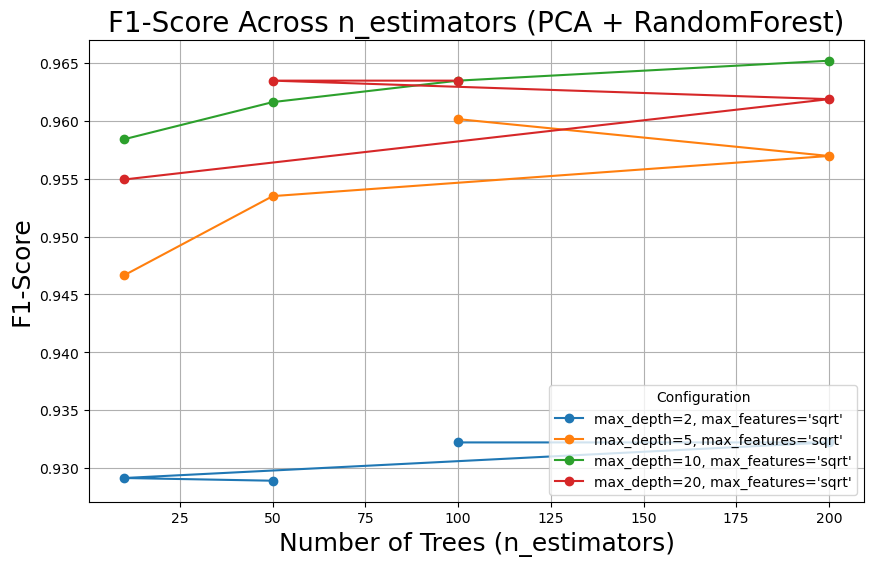

In [19]:
plt.figure(figsize=(10, 6))

# Step 10: Visualize F1-score across n_neighbors
plt.figure(figsize=(10, 6))
for depth in max_depth_values:
    #for mf in max_features_values:
        #subset = results_df[(results_df['weights'] == weight) & (results_df['p'] == p)]
    subset_df = results_df[(results_df['max_depth'] == depth) & (results_df['max_features'] == 'sqrt')]
    plt.plot(subset_df['n_estimators'], subset_df['f1'], marker='o', label=f"max_depth={depth}, max_features='sqrt'")


#plt.plot(subset_df['n_estimators'], subset_df['f1'], marker='o', label=f"max_depth={optimal_depth}, max_features='sqrt'")
plt.title('F1-Score Across n_estimators (PCA + RandomForest)', fontsize=20)
plt.xlabel('Number of Trees (n_estimators)', fontsize=18)
plt.ylabel('F1-Score', fontsize=18)
plt.legend(title="Configuration", loc='lower right')
plt.grid(True)
plt.show()

#### Optimal RandomForest parameters for PCA


Confusion Matrix:
[[285  15]
 [ 26 274]]


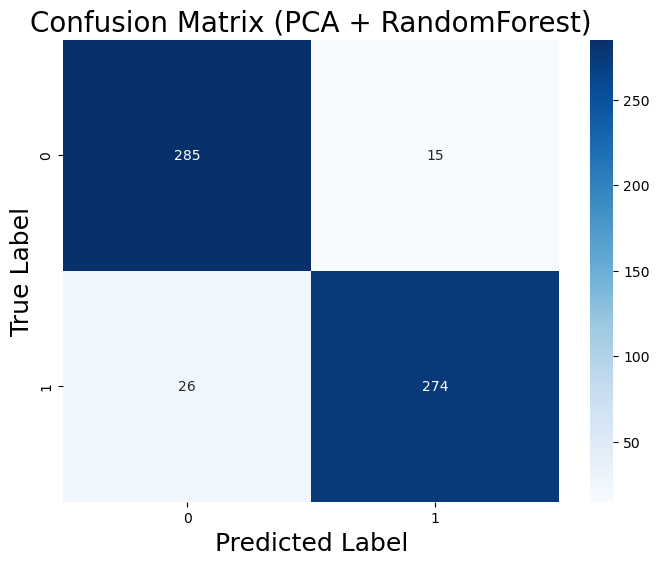

Overall Accuracy (PCA + RandomForest): 0.93
Precision (Weighted): 0.93
Recall (Weighted): 0.93
F1-Score (Weighted): 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       300
           1       0.95      0.91      0.93       300

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



In [106]:
optimal_n = best_config['n_estimators']
optimal_depth = best_config['max_depth']
optimal_mf = best_config['max_features']

# Step 1: Extract PCA-transformed features and labels (if not already done)
# Assuming df_pca has PC1, PC2 and 'class' columns:
X = df_pca[['PC1', 'PC2']].values  
y = df_pca['class'].values

# Step 2: Use the reusable function to split data
X_train, X_test, y_train, y_test = split_train_test(X, y, stratify=y)

# Step 3: Train the Random Forest classifier with the optimal parameters
rf_pca_optimal = RandomForestClassifier(n_estimators=optimal_n, max_depth=int(optimal_depth), max_features=optimal_mf, random_state=42)
rf_pca_optimal.fit(X_train, y_train)

# Step 4: Predict on the test set
y_pred = rf_pca_optimal.predict(X_test)

# Step 5: Evaluate the model
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(y)), yticklabels=sorted(set(y)))
plt.title("Confusion Matrix (PCA + RandomForest)", fontsize=20)
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
plt.show()

# Step 6: Calculate metrics (weighted for multiclass)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Step 7: Display metrics
print(f"Overall Accuracy (PCA + RandomForest): {accuracy:.2f}")
print(f"Precision (Weighted): {precision:.2f}")
print(f"Recall (Weighted): {recall:.2f}")
print(f"F1-Score (Weighted): {f1:.2f}")

# Step 8: Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#### RandomForest results for PCA - correct vs misclassified

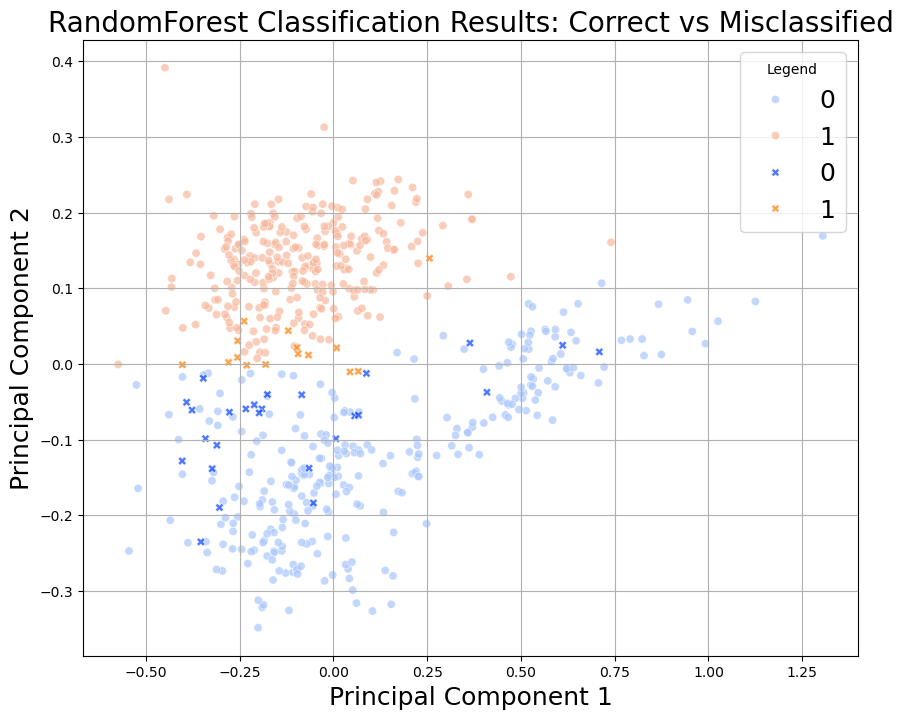

In [107]:
# Add true and predicted labels to the test set
test_results = pd.DataFrame(X_test, columns=['PC1', 'PC2'])
test_results['true_label'] = y_test
test_results['predicted_label'] = y_pred
test_results['is_correct'] = test_results['true_label'] == test_results['predicted_label']

# Separate correct and incorrect predictions
correct_points = test_results[test_results['is_correct']]
incorrect_points = test_results[~test_results['is_correct']]

# Plot Correct Predictions
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=correct_points,
    x='PC1', y='PC2',
    hue='true_label',
    palette='coolwarm',
    marker='o',  # Circles for correct points
    alpha=0.7,
    legend='full'
)

# Plot Incorrect Predictions
sns.scatterplot(
    data=incorrect_points,
    x='PC1', y='PC2',
    hue='predicted_label',
    palette='bright',
    marker='X',  # Crosses for incorrect points
    alpha=0.7,
    legend='full'
)

# Add titles and labels
plt.title("RandomForest Classification Results: Correct vs Misclassified", fontsize=20)
plt.xlabel("Principal Component 1", fontsize=18)
plt.ylabel("Principal Component 2", fontsize=18)
plt.legend(title="Legend", fontsize=18)
plt.grid(True)
plt.show()

#### OK lets descirbe those points and see what we have

In [61]:
correct_stats = correct_points.describe(include='all')
incorrect_stats = incorrect_points.describe(include='all')

In [62]:
print('Teisingai suklasifikuoti taskai:', correct_stats.loc['count', 'is_correct'])

Teisingai suklasifikuoti taskai: 559


In [63]:
print('NEteisingai suklasifikuoti taskai:', incorrect_stats.loc['count', 'is_correct'])

NEteisingai suklasifikuoti taskai: 41


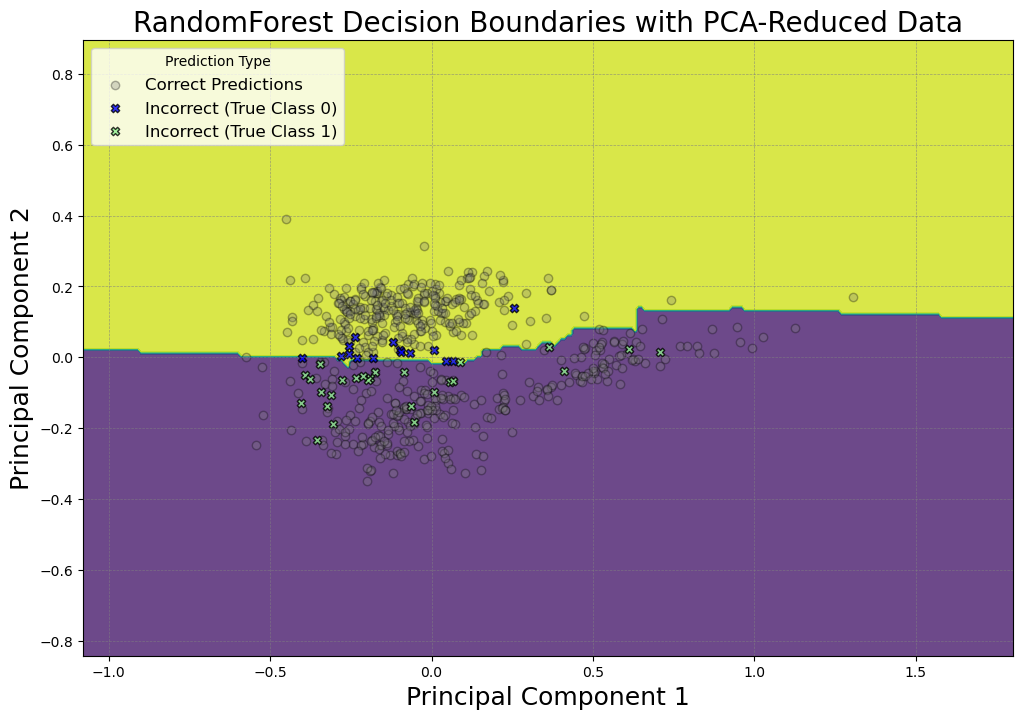

In [108]:
# Step 1: Create a mesh grid over the PCA-reduced space
x_min, x_max = X_test_pca[:, 0].min() - 0.5, X_test_pca[:, 0].max() + 0.5
y_min, y_max = X_test_pca[:, 1].min() - 0.5, X_test_pca[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Step 2: Predict on the mesh grid using the trained RandomForest model
grid = np.c_[xx.ravel(), yy.ravel()]
grid_original_space = pca.inverse_transform(grid)  # Map grid points back to the original space
Z = rf_pca_optimal.predict(grid_original_space)  # Predict using the RandomForest model
Z = Z.reshape(xx.shape)

# Step 3: Visualize the decision boundaries
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')  # Decision regions

# Step 4: Overlay the classification points
# Correct Predictions (grey color with low opacity)
plt.scatter(
    correct_points['PC1'],
    correct_points['PC2'],
    c='grey',
    marker='o',
    alpha=0.3,
    edgecolor='k',
    label='Correct Predictions'
)

# Incorrect Predictions (different colors for each misclassified class)
for class_label, color in zip(sorted(set(y_test)), ['blue', 'lightgreen', 'red']):
    class_incorrect = incorrect_points[incorrect_points['true_label'] == class_label]
    plt.scatter(
        class_incorrect['PC1'],
        class_incorrect['PC2'],
        c=color,
        marker='X',
        alpha=0.8,
        edgecolor='k',
        label=f'Incorrect (True Class {class_label})'
    )

# Step 5: Add plot details
plt.title("RandomForest Decision Boundaries with PCA-Reduced Data", fontsize=20)
plt.xlabel("Principal Component 1", fontsize=18)
plt.ylabel("Principal Component 2", fontsize=18)

# Add legend and grid
plt.legend(title="Prediction Type", loc='upper left', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()


## RandomForest for original data(6 features, not dimensionality reduced to 2 - more data, more precise)

#### Testing 3 parameters of RandomForest for original 6 features

Top 5 configurations based on F1-Score:
    n_estimators  max_depth max_features       f1
28           200         10         sqrt 0.965174
29           200         10         log2 0.965174
23           100         20         log2 0.963455
22           100         20         sqrt 0.963455
21           100         10         log2 0.963455

Most Optimal Configuration:
n_estimators: 200, max_depth: 10, max_features: sqrt, F1-Score: 0.97


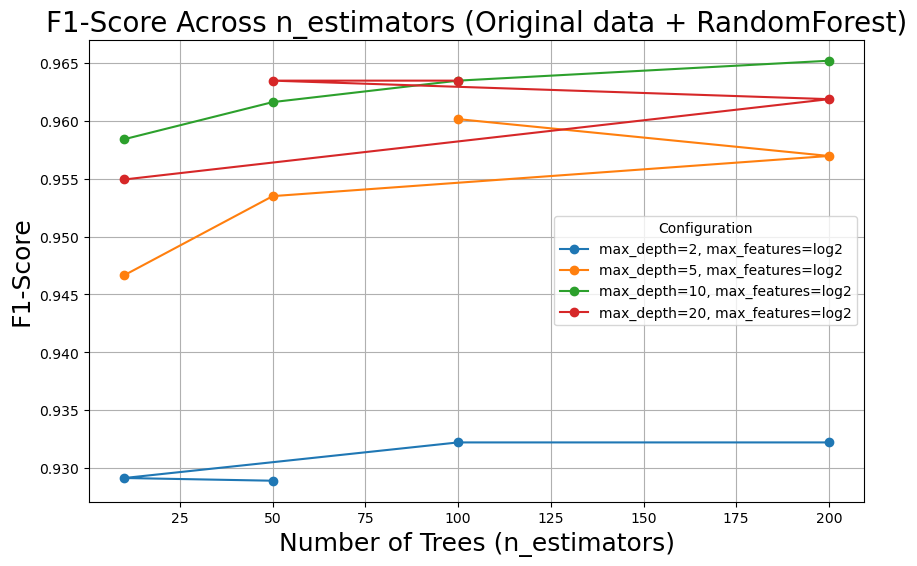

In [16]:
# Step 1: Extract original features and labels
X = dfminmax[['u', 'g', 'r', 'i', 'z', 'redshift']].values  # Original features
y = dfminmax['class'].values                                # Labels (class 1 and 2)

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = split_train_test(X, y, stratify=y)

# Step 3: Define parameters to test
n_estimators_values = [10, 50, 100, 200]
max_depth_values = [2, 5, 10, 20]
max_features_values = ['sqrt', 'log2']

# Step 4: Store results
results = []

# Step 5: Test each combination
for n in n_estimators_values:
    for depth in max_depth_values:
        for mf in max_features_values:
            # Initialize and train RandomForest
            rf = RandomForestClassifier(n_estimators=n, max_depth=depth, max_features=mf, random_state=42)
            rf.fit(X_train, y_train)
            
            # Predict
            y_pred = rf.predict(X_test)
            
            # Calculate F1-score (weighted to handle multiclass or imbalanced data)
            f1 = f1_score(y_test, y_pred, average='binary', pos_label = 0)
            
            # Store results
            results.append({
                'n_estimators': n,
                'max_depth': depth,
                'max_features': mf,
                'f1': f1
            })

# Step 6: Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results)

# Step 7: Display and sort results by F1-score
results_df = results_df.sort_values(by='f1', ascending=False)
print("Top 5 configurations based on F1-Score:")
print(results_df.head())

# Step 8: Display the most optimal configuration
best_config = results_df.iloc[0]
print("\nMost Optimal Configuration:")
print(f"n_estimators: {best_config['n_estimators']}, max_depth: {best_config['max_depth']}, max_features: {best_config['max_features']}, F1-Score: {best_config['f1']:.2f}")

# Step 9: Visualize F1-score across n_neighbors
plt.figure(figsize=(10, 6))
for depth in max_depth_values:
    subset_df = results_df[(results_df['max_depth'] == depth) & (results_df['max_features'] == optimal_mf)]
    plt.plot(subset_df['n_estimators'], subset_df['f1'], marker='o', label=f"max_depth={depth}, max_features={optimal_mf}")


#plt.plot(subset_df['n_estimators'], subset_df['f1'], marker='o', label=f"max_depth={optimal_depth}, max_features={optimal_mf}")
plt.title('F1-Score Across n_estimators (Original data + RandomForest)', fontsize=20)
plt.xlabel('Number of Trees (n_estimators)', fontsize=18)
plt.ylabel('F1-Score', fontsize=18)
plt.legend(title="Configuration", loc='center right')
plt.grid(True)
plt.show()


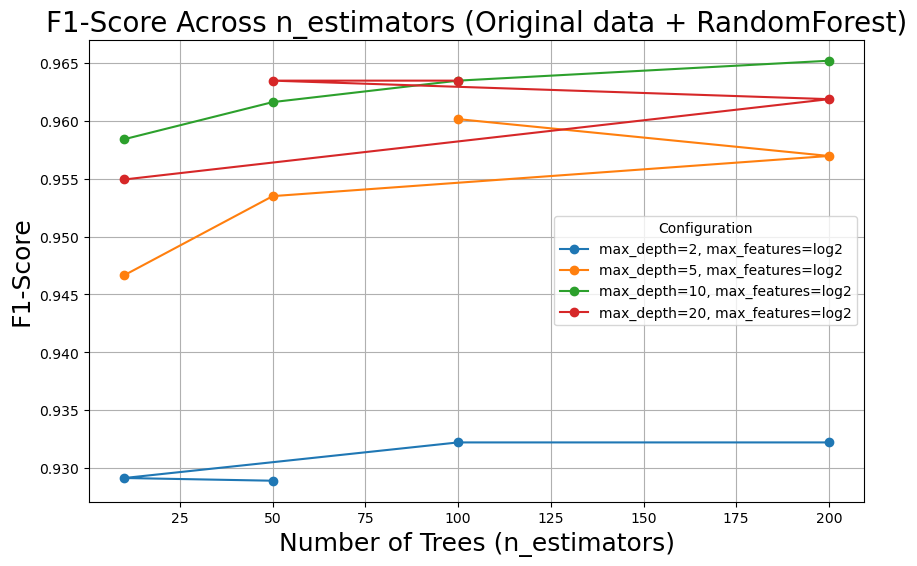

In [17]:
# Step 9: Visualize F1-score across n_neighbors
plt.figure(figsize=(10, 6))
for depth in max_depth_values:
    subset_df = results_df[(results_df['max_depth'] == depth) & (results_df['max_features'] == 'log2')]
    plt.plot(subset_df['n_estimators'], subset_df['f1'], marker='o', label=f"max_depth={depth}, max_features={optimal_mf}")


#plt.plot(subset_df['n_estimators'], subset_df['f1'], marker='o', label=f"max_depth={optimal_depth}, max_features={optimal_mf}")
plt.title('F1-Score Across n_estimators (Original data + RandomForest)', fontsize=20)
plt.xlabel('Number of Trees (n_estimators)', fontsize=18)
plt.ylabel('F1-Score', fontsize=18)
plt.legend(title="Configuration", loc='center right')
plt.grid(True)
plt.show()

#### Optimal RandomForest parameters for original data 

In [118]:
# Suppose from the results we get something like: n_estimators=100, max_depth=10, max_features='sqrt'
# (Use the actual best_config values from above)
optimal_n = best_config['n_estimators']
optimal_depth = best_config['max_depth']
optimal_mf = best_config['max_features']

# Step 1: Extract original features and labels again (if needed)
X = dfminmax[['u', 'g', 'r', 'i', 'z', 'redshift']].values
y = dfminmax['class'].values

# Step 2: Split data into training and testing sets again
X_train, X_test, y_train, y_test = split_train_test(X, y, stratify=y)


Confusion Matrix:
[[291   9]
 [ 12 288]]


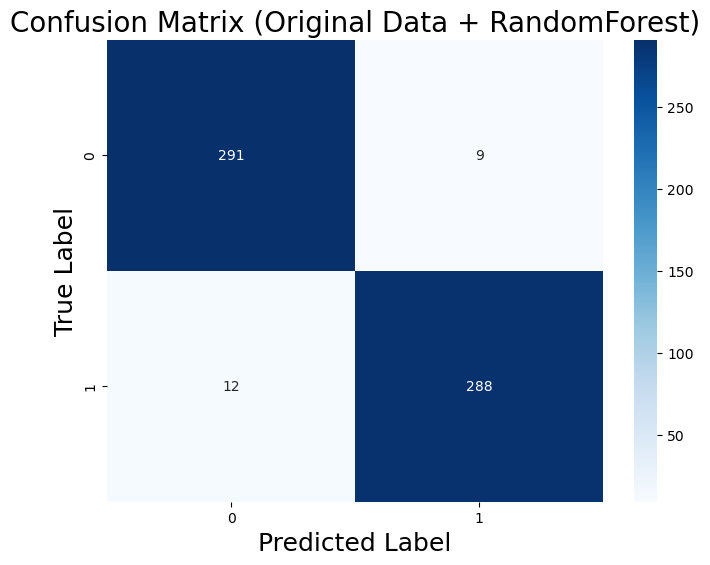

Overall Accuracy (Original Data + RandomForest): 0.96
Precision (Weighted): 0.97
Recall (Weighted): 0.96
F1-Score (Weighted): 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       300
           1       0.97      0.96      0.96       300

    accuracy                           0.96       600
   macro avg       0.97      0.96      0.96       600
weighted avg       0.97      0.96      0.96       600



In [119]:
optimal_n = best_config['n_estimators']
optimal_depth = best_config['max_depth']
optimal_mf = best_config['max_features']

# Step 1: Extract original features and labels again (if needed)
X = dfminmax[['u', 'g', 'r', 'i', 'z', 'redshift']].values
y = dfminmax['class'].values

# Step 2: Split data into training and testing sets again
X_train, X_test, y_train, y_test = split_train_test(X, y, stratify=y)

# Step 3: Train the RandomForest classifier with the optimal parameters
rf_orig_optimal = RandomForestClassifier(n_estimators=optimal_n, max_depth=int(optimal_depth), max_features=optimal_mf, random_state=42)
rf_orig_optimal.fit(X_train, y_train)

# Step 4: Predict on the test set
y_pred = rf_orig_optimal.predict(X_test)

# Step 5: Evaluate the model
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(y)), yticklabels=sorted(set(y)))
plt.title("Confusion Matrix (Original Data + RandomForest)", fontsize=20)
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
plt.show()

# Step 6: Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Step 7: Display metrics
print(f"Overall Accuracy (Original Data + RandomForest): {accuracy:.2f}")
print(f"Precision (Weighted): {precision:.2f}")
print(f"Recall (Weighted): {recall:.2f}")
print(f"F1-Score (Weighted): {f1:.2f}")

# Step 8: Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#### Ok lets describe again, this time better

#### RandomForest decision boundaries

## K-fold cross-validation - original data with 6 features + RandomForest, PCA + RandomForest

             Dataset  Mean F1-Score  Std F1-Score
0  Original Features       0.954658      0.014241
1    PCA Transformed       0.935273      0.008446


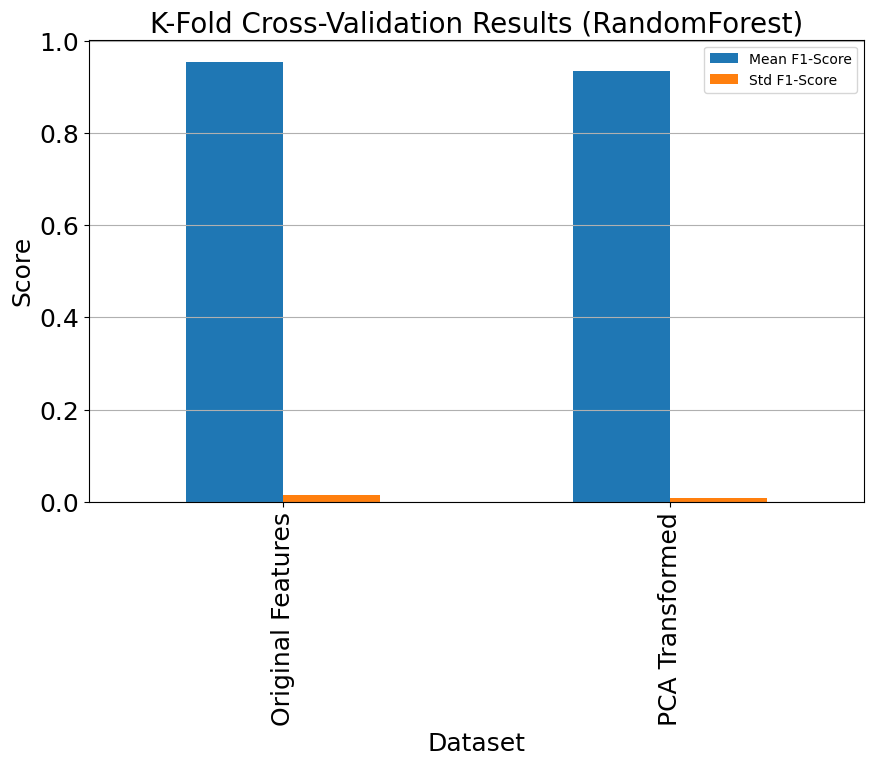

In [121]:
def evaluate_rf_with_kfold(X, y, name, rf, k=5):    
    # Stratified K-Fold
    stratified_kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Perform cross-validation with 'f1_weighted'
    cv_scores = cross_val_score(rf, X, y, cv=stratified_kfold, scoring='f1_weighted')
    
    return {
        "Dataset": name,
        "Mean F1-Score": np.mean(cv_scores),
        "Std F1-Score": np.std(cv_scores)
    }


# Step 1: Prepare datasets
datasets = []

# Original 6 features
X_original = dfminmax_test[['u', 'g', 'r', 'i', 'z', 'redshift']].values
y_original = dfminmax_test['class'].values
datasets.append(("Original Features", X_original, y_original, rf_orig_optimal))

# PCA-transformed features
X_pca = df_pca[['PC1', 'PC2']].values
y_pca = df_pca['class'].values
datasets.append(("PCA Transformed", X_pca, y_pca, rf_pca_optimal))

# Step 2: Perform k-fold cross-validation for each dataset
results = []
for name, X, y, rf in datasets:
    result = evaluate_rf_with_kfold(X, y, name, rf)
    results.append(result)

# Step 3: Display results
results_df = pd.DataFrame(results)
print(results_df)

# Step 4: Visualize results
results_df.plot(x="Dataset", y=["Mean F1-Score", "Std F1-Score"], kind="bar", figsize=(10, 6), fontsize=18, legend=True)
plt.title("K-Fold Cross-Validation Results (RandomForest)", fontsize=20)
plt.xlabel("Dataset", fontsize=18)
plt.ylabel("Score", fontsize=18)
plt.grid(axis="y")
plt.show()

## ROC Curve(ROC is the graph, AUC is the value)

Computing ROC for Original Features...


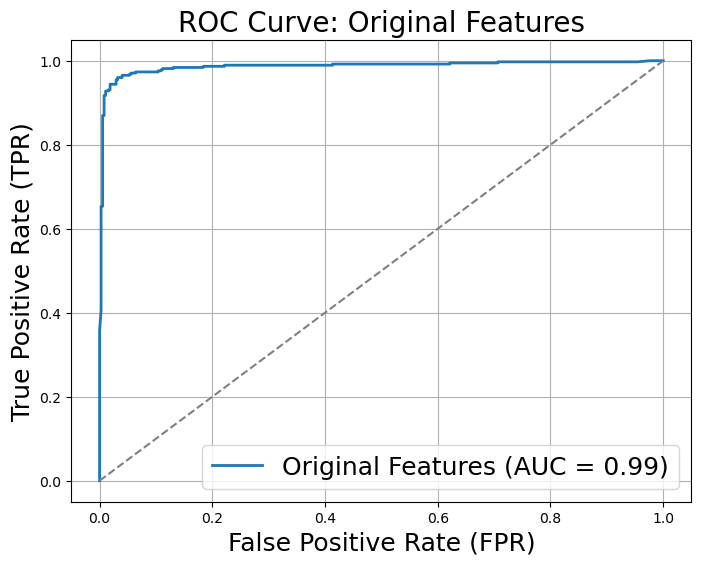

Computing ROC for PCA Transformed Features...


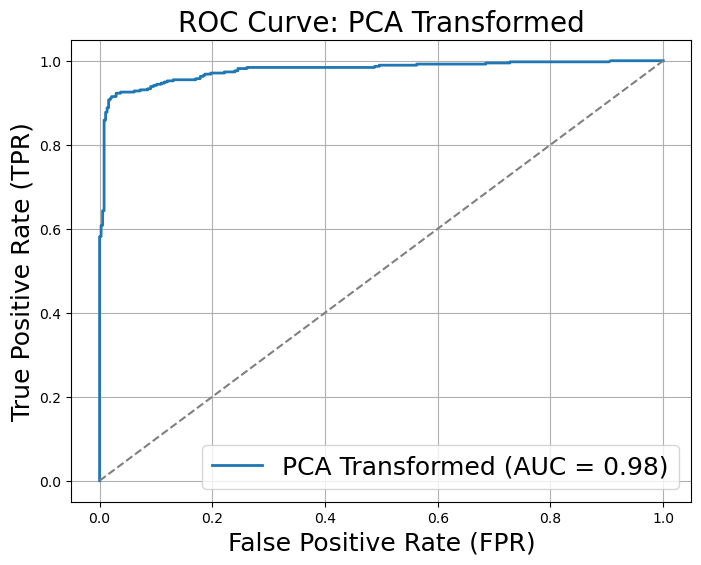

Original Features - AUC: 0.9866595555555556
PCA Transformed Features - AUC: 0.9775573333333333


In [138]:
def compute_and_plot_roc(model, X_test, y_test, name):

    
    # Predict probabilities
    unique_classes = np.unique(y_test)
    y_prob = model.predict_proba(X_test)
    
    y_prob_pos = y_prob[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob_pos, pos_label=1)
    auc_score = roc_auc_score(y_test, y_prob_pos)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})", linewidth=2)
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title(f"ROC Curve: {name}", fontsize=20)
    plt.xlabel("False Positive Rate (FPR)", fontsize=18)
    plt.ylabel("True Positive Rate (TPR)", fontsize=18)
    plt.legend(loc="lower right", fontsize=18)
    plt.grid(True)
    plt.show()
    return auc_score


X_test_original = dfminmax_test[['u', 'g', 'r', 'i', 'z', 'redshift']].values
y_test_original = dfminmax_test['class'].values

# PCA Transformation on the already scaled training and test sets
pca = PCA(n_components=2)
X_train_original = dfminmax[['u', 'g', 'r', 'i', 'z', 'redshift']].values
X_train_pca = pca.fit_transform(X_train_original)
X_test_pca = pca.transform(X_test_original)

# Evaluate and plot ROC for each dataset using the already trained models
results = []

# Original Features
print("Computing ROC for Original Features...")
auc_original = compute_and_plot_roc(rf_orig_optimal, X_test_original, y_test_original, "Original Features")
results.append({"Dataset": "Original Features", "AUC": auc_original})

# PCA Transformed Features
print("Computing ROC for PCA Transformed Features...")
auc_pca = compute_and_plot_roc(rf_pca_optimal, X_test_pca, y_test_original, "PCA Transformed")
results.append({"Dataset": "PCA Transformed Features", "AUC": auc_pca})

# Display results
for result in results:
    print(f"{result['Dataset']} - AUC: {result['AUC']}")


## Paziurim kokie taskai buvo predictinti blogai su geriausiu modeliu pagal ROC kreives

In [151]:
y_pred = rf_orig_optimal.predict(X_test_original)

# Add true and predicted labels to the test set
test_results = pd.DataFrame(X_test, columns=feature_cols)
test_results['true_label'] = y_test_original
test_results['predicted_label'] = y_pred
test_results['is_correct'] = test_results['true_label'] == test_results['predicted_label']

# Separate correct and incorrect predictions
correct_points = test_results[test_results['is_correct']]
incorrect_points = test_results[~test_results['is_correct']]

In [143]:
len(correct_points)/len(test_results)*100

95.86666666666666

In [20]:
incorrect_points

NameError: name 'incorrect_points' is not defined

In [148]:
incorrect_points[feature_cols].describe()

,redshift,u,g,r,i,z
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.090154,0.604715,0.624085,0.668039,0.626996,0.675413
std,0.051914,0.152515,0.118294,0.134038,0.126507,0.132429
min,0.003946,0.253283,0.331845,0.361960,0.344763,0.384687
25%,0.044203,0.502618,0.583148,0.587075,0.546648,0.597100
50%,0.097346,0.620977,0.649653,0.696725,0.659946,0.700168
75%,0.139096,0.700490,0.690880,0.759361,0.727856,0.771944
max,0.169575,0.896239,0.845521,0.900784,0.827220,0.872284


In [149]:
correct_points[feature_cols].describe()

,redshift,u,g,r,i,z
count,719.000000,719.000000,719.000000,719.000000,719.000000,719.000000
mean,0.150977,0.551804,0.565643,0.595832,0.570272,0.620865
std,0.127418,0.155390,0.129885,0.131736,0.129415,0.148519
min,0.000011,0.038749,0.064007,0.081768,0.082205,0.086406
25%,0.062377,0.434885,0.495342,0.534210,0.502366,0.539662
50%,0.102867,0.545472,0.587026,0.622499,0.583282,0.634706
75%,0.229061,0.647722,0.651953,0.694325,0.665679,0.727450
max,0.782144,1.000000,0.946634,0.860429,0.899869,0.924420


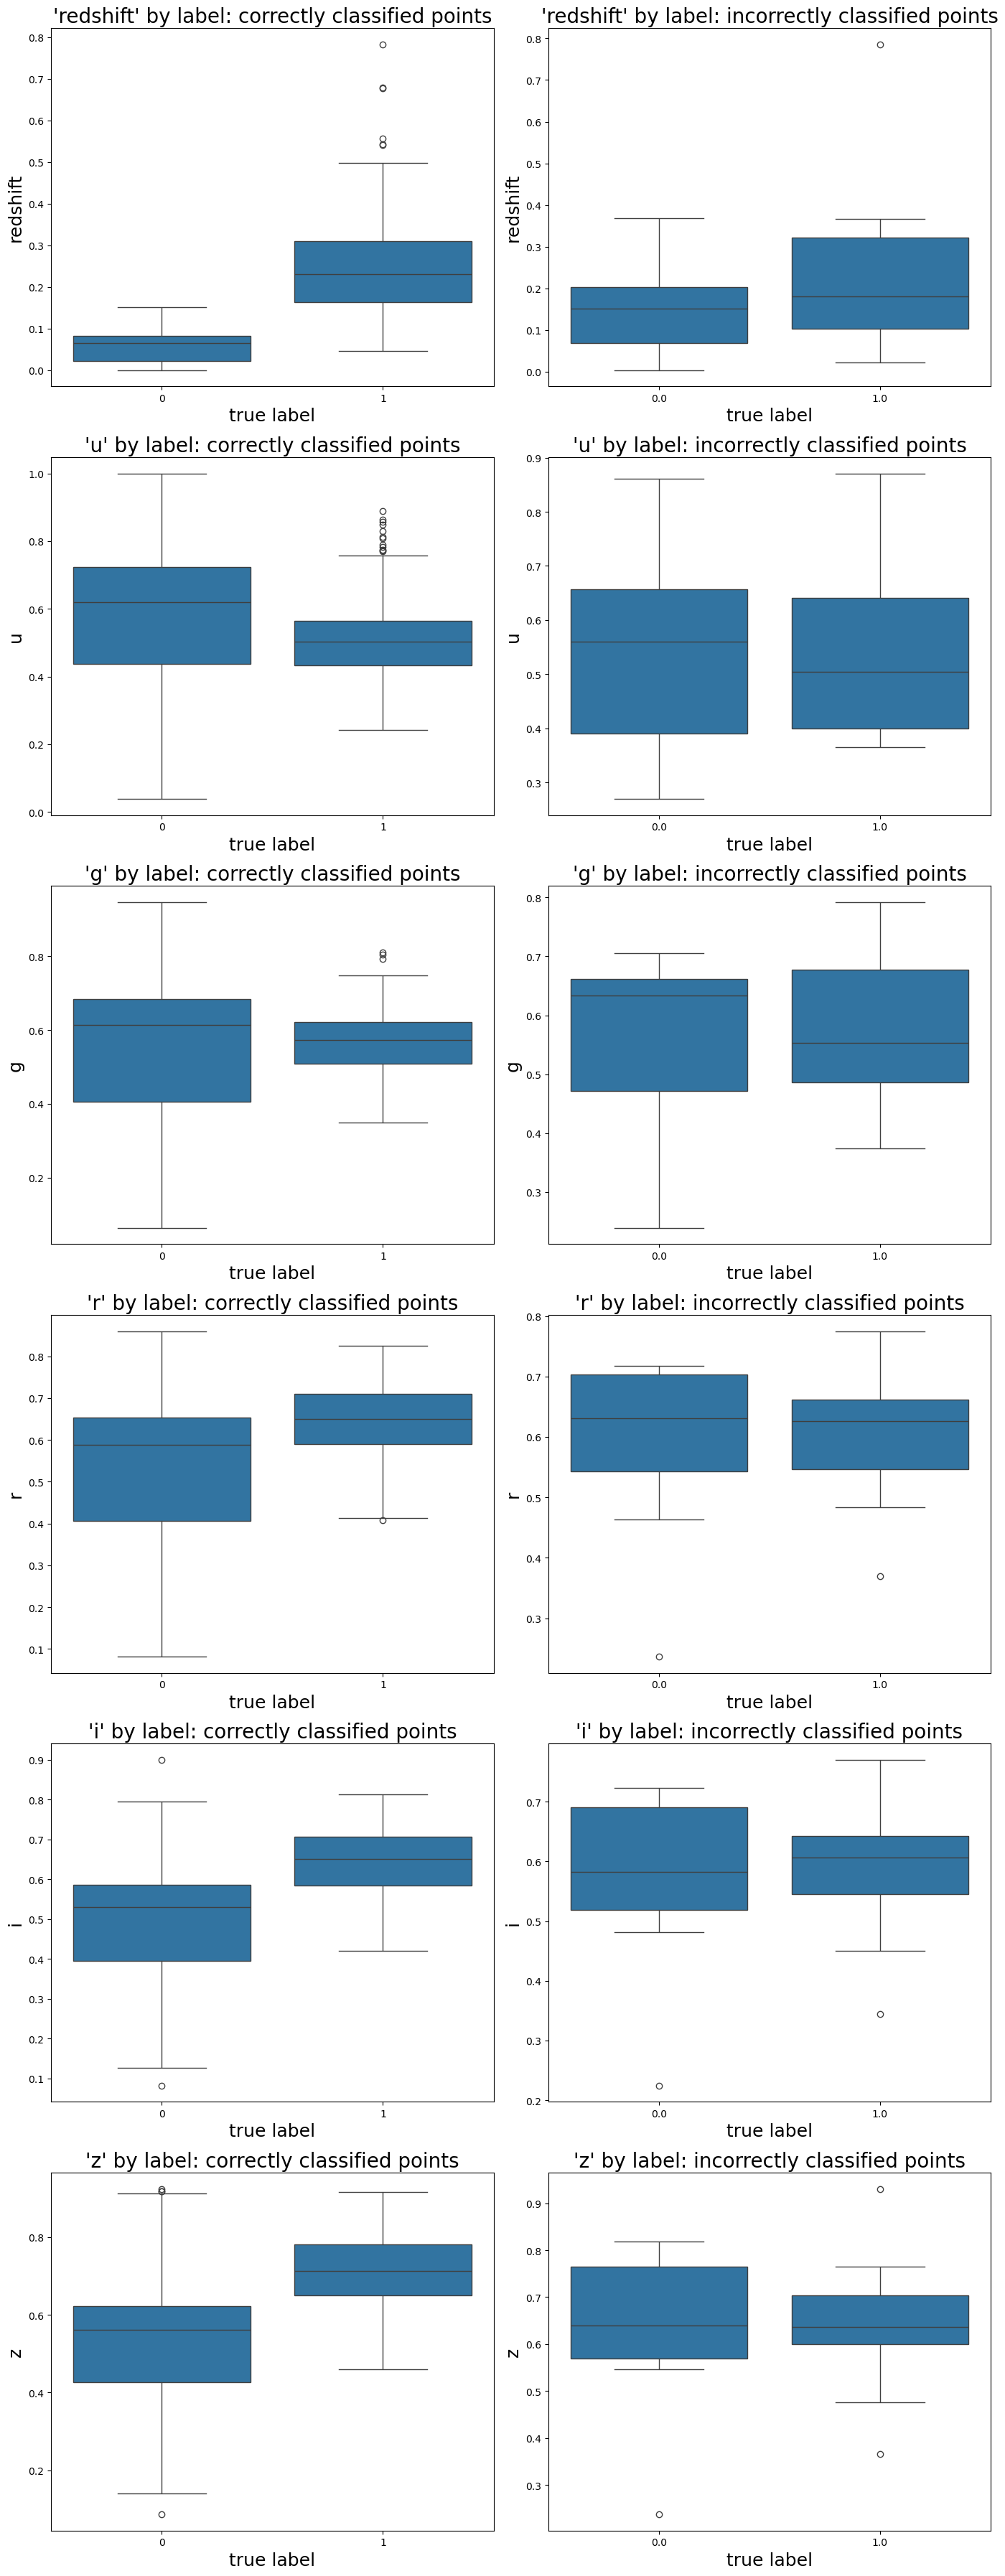

In [145]:
plt.figure(figsize=(14, 36))

i = 1
for col in feature_cols:
    plt.subplot(6, 2, i)
    sns.boxplot(x=correct_points['true_label'], y=correct_points[col])
    plt.title(f"'{col}' by label: correctly classified points", fontsize=20)
    plt.xlabel("true label", fontsize=18)
    plt.ylabel(col, fontsize=18)
    i += 1
    
    # Boxplot for 'redshift' by 'class'
    plt.subplot(6, 2, i)
    sns.boxplot(x=incorrect_points['true_label'], y=dfminmax[col])
    plt.title(f"'{col}' by label: incorrectly classified points", fontsize=20)
    plt.xlabel("true label", fontsize=18)
    plt.ylabel(col, fontsize=18)
    i += 1

plt.tight_layout()
plt.show()